In [ ]:
# https://github.com/ooleksyuk/CarND-Semantic-Segmentation/blob/master/main.py

In [1]:
# %load main.py
import os.path
import tensorflow as tf
import helper
import warnings
import ssl
import project_tests as tests
import scipy
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from distutils.version import LooseVersion
from moviepy.editor import VideoFileClip

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion(
    '1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn(
        'No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


NUM_CLASSES = 2
KEEP_PROB = 1.0
LEARNING_RATE = 1e-3
EPOCHS = 40
BATCH_SIZE = 32
L2_REG = 1e-6
STDDEV = 0.01


def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    layers = ('image_input:0', 'keep_prob:0',
              'layer3_out:0', 'layer4_out:0', 'layer7_out:0')
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    return (graph.get_tensor_by_name(l) for l in layers)


tests.test_load_vgg(load_vgg, tf)


def conv1x1(value, num_classes):
    return tf.layers.conv2d(value,
                            num_classes, 1,
                            padding='same',
                            kernel_initializer=tf.random_normal_initializer(
                                stddev=STDDEV),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))


def deconv(value, num_classes, kernel_size, strides):
    return tf.layers.conv2d_transpose(value,
                                      num_classes,
                                      kernel_size,
                                      strides=strides,
                                      padding='same',
                                      kernel_initializer=tf.random_normal_initializer(
                                          stddev=STDDEV),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    conv_1x1 = conv1x1(vgg_layer7_out, num_classes)

    deconv_1 = deconv(conv_1x1, num_classes, 4, strides=(2, 2))
    deconv_1 = tf.add(deconv_1, conv1x1(vgg_layer4_out, num_classes))

    deconv_2 = deconv(deconv_1, num_classes, 4, strides=(2, 2))
    deconv_2 = tf.add(deconv_2, conv1x1(vgg_layer3_out, num_classes))
    return deconv(deconv_2, num_classes, 16, strides=(8, 8))


tests.test_layers(layers)


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=correct_label))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return logits, optimizer, loss


tests.test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    losses = []
    for epoch in range(epochs):
        desc = "Epoch {0}/{1}".format(epoch+1, epochs)
        for images, labels in tqdm(get_batches_fn(batch_size), desc=desc):
            _, loss = sess.run([train_op, cross_entropy_loss],
                               feed_dict={input_image: images,
                                          correct_label: labels,
                                          keep_prob: KEEP_PROB,
                                          learning_rate: LEARNING_RATE})
            losses.append(loss)
    return losses


tests.test_train_nn(train_nn)


def download_vgg(data_dir):
    """
    Bypass the SSL certificate exceptions by creating the unverified context
    """
    ssl._create_default_https_context = ssl._create_unverified_context
    helper.maybe_download_pretrained_vgg(data_dir)

def process_video(sess, logits, keep_prob, input_image, input_file, output_file):
    image_shape = (704, 1280)

    def process_frame(frame):
        frame = scipy.misc.imresize(frame, image_shape)
        im_softmax = sess.run([tf.nn.softmax(logits)], {keep_prob: 1.0, input_image: [frame]})
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(frame)
        street_im.paste(mask, box=None, mask=mask)
        return np.array(street_im)

    video = VideoFileClip(input_file)
    processed = video.fl_image(process_frame)
    processed.write_videofile(output_file, audio=False)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0
Tests Passed
Tests Passed


Epoch 1/1: 100%|██████████| 2/2 [00:00<00:00, 500.48it/s]


Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


In [2]:
def plot_loss(loss, output_file):
    plt.plot(loss)
    plt.title('Cross-entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.ylim(0, 1)
    plt.savefig(output_file)

Epoch 1/40: 10it [00:57,  4.28s/it]
Epoch 2/40: 10it [00:41,  3.35s/it]
Epoch 3/40: 10it [00:41,  3.35s/it]
Epoch 4/40: 10it [00:41,  3.36s/it]
Epoch 5/40: 10it [00:41,  3.35s/it]
Epoch 6/40: 10it [00:41,  3.35s/it]
Epoch 7/40: 10it [00:41,  3.34s/it]
Epoch 8/40: 10it [00:41,  3.35s/it]
Epoch 9/40: 10it [00:41,  3.35s/it]
Epoch 10/40: 10it [00:41,  3.35s/it]
Epoch 11/40: 10it [00:41,  3.33s/it]
Epoch 12/40: 10it [00:41,  3.34s/it]
Epoch 13/40: 10it [00:42,  3.36s/it]
Epoch 14/40: 10it [00:41,  3.33s/it]
Epoch 15/40: 10it [00:41,  3.34s/it]
Epoch 16/40: 10it [00:41,  3.34s/it]
Epoch 17/40: 10it [00:41,  3.33s/it]
Epoch 18/40: 10it [00:41,  3.34s/it]
Epoch 19/40: 10it [00:41,  3.34s/it]
Epoch 20/40: 10it [00:41,  3.34s/it]
Epoch 21/40: 10it [00:41,  3.35s/it]
Epoch 22/40: 10it [00:41,  3.34s/it]
Epoch 23/40: 10it [00:41,  3.35s/it]
Epoch 24/40: 10it [00:41,  3.35s/it]
Epoch 25/40: 10it [00:41,  3.34s/it]
Epoch 26/40: 10it [00:41,  3.34s/it]
Epoch 27/40: 10it [00:41,  3.33s/it]
Epoch 28/4

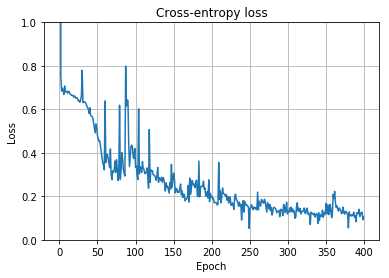

In [3]:
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'
tests.test_for_kitti_dataset(data_dir)

# Download pretrained vgg model
download_vgg(data_dir)

# OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
# You'll need a GPU with at least 10 teraFLOPS to train on.
#  https://www.cityscapes-dataset.com/

with tf.Session() as sess:
    vgg_path = os.path.join(data_dir, 'vgg')
    get_batches_fn = helper.gen_batch_function(
        os.path.join(data_dir, 'data_road/training'), image_shape)

    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    load_vgg(sess, vgg_path)
    input_image, keep_prob, layer3, layer4, layer7 = load_vgg(
        sess, vgg_path)
    output_layer = layers(layer3, layer4, layer7, NUM_CLASSES)

    correct_label = tf.placeholder(dtype=tf.float32, shape=(
        None, None, None, NUM_CLASSES), name='correct_label')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    logits, train_op, cross_entropy_loss = optimize(
        output_layer, correct_label, learning_rate, NUM_CLASSES)

    sess.run(tf.global_variables_initializer())
    losses = train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op,
                      cross_entropy_loss, input_image, correct_label, keep_prob, learning_rate)

    helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
    plot_loss(losses, 'cross-entropy.png')
    # process_video(sess, logits, keep_prob, input_image, 'project_video.mp4', 'output_video.mp4')

In [ ]:
losses

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(losses)
plt.ylim(0, 1)